In [85]:
import kagglehub #data seti alma

# Download latest version
path = kagglehub.dataset_download("zgnbyktanr/turkish-psychological-classification-for-nlp")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/zgnbyktanr/turkish-psychological-classification-for-nlp/versions/1


In [86]:
import pandas as pd   #veri işleme ve analizi
import numpy as np    #bilimsel veriler
from sklearn.model_selection import train_test_split  #test seti ve eğitim seti ayrıması
from sklearn.feature_extraction.text import TfidfVectorizer #vectorizer
from sklearn.linear_model import LogisticRegression  #clasification
from sklearn.metrics import accuracy_score, classification_report #model doğruluğunu ölçme
import nltk #ön işleme için
from nltk.corpus import stopwords #a, and, the, etc.
import re #özel karakter ve sayı çıkarma
from imblearn.over_sampling import SMOTE  #denge için
from collections import Counter #veri saymak için
import tensorflow as tf    #neural network için
from tensorflow.keras.models import Sequential  #dl katmanlı hali
from tensorflow.keras.layers import Dense, Dropout  #sinir ağı katmanı ve overfitting engelleme

In [87]:
#nltk stopword TÜRKÇE olanları yükleme
nltk.download('stopwords')
stop_words = set(stopwords.words('turkish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [88]:
import os

# Dosya yolundaki dosyaları listeleme
dataset_path = '/root/.cache/kagglehub/datasets/zgnbyktanr/turkish-psychological-classification-for-nlp/versions/1'
files = os.listdir(dataset_path)
print(files) #dosya isimlerini yazdırma



['dataset.csv', 'test.xlsx']


In [89]:
import pandas as pd

# dosya yolunu okuma
file_path = '/root/.cache/kagglehub/datasets/zgnbyktanr/turkish-psychological-classification-for-nlp/versions/1/dataset.csv'
df = pd.read_csv(file_path)

# İlk 10 satır inceleme
print(df.head(10))



                                                text  label
0  İlişkilerimde aşırı derecede idealize edip son...      6
1  Bir gece uykumda yürüyüp dolaptan kıyafetlerim...      2
2  Kumar borçlarım yüzünden evliliğim tehlikede. ...      4
3  Uykum çok hafif ve en ufak bir sesle bile uyan...      2
4  Kumar borçlarımı ödemek için çaldığım paraları...      4
5  Bir hırsızlık olayına şahit oldum ve bu durum ...     14
6  Cinsel ilişki sırasında boşalamadığım için ken...      3
7  Kendime olan güvenim tamamen yok oldu. Yaptığı...     10
8  İşyerinde terfi alamadığımdan beri 2 yıl geçti...     10
9  Çalmak için plan yapıyorum ve çaldığımda çok h...      4


In [90]:
# Veri Ön İşleme
def clean_text(text):
    text = text.lower() #küçük harf yapma
    text = re.sub(r'[^\w\s]', '', text) #noktları kaldırma
    text = re.sub(r'\d+', '', text) #sayıları kaldırma
    text = ' '.join(word for word in text.split() if word not in stop_words)  #metni boşluklara bölme ve stopword kaldırma
    return text

df['cleaned_text'] = df['text'].apply(clean_text) #veri setine uygulama

In [91]:
# Veri setini eğitim ve test setine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [92]:
# denge için SMOTE uygulama
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [93]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")
model = AutoModel.from_pretrained("dbmdz/bert-base-turkish-cased")

def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    return torch.mean(outputs.last_hidden_state, dim=1).detach().numpy()

X = np.array([get_bert_embeddings(text) for text in df['cleaned_text']])


In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# Her örnek için kelime vektörlerinin ortalamasını alma
X = np.array([np.mean(embedding, axis=0) for embedding in X])  # X şimdi 2 boyutlu (num_samples, feature_dim)

# Eğitim ve test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE ile sınıf dengesini çözme
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Lojistik Regresyon Modeli
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_resampled, y_train_resampled)

# Test seti tahmini
y_pred_logistic = logistic_model.predict(X_test)

# Performans değerlendirme
print("Lojistik Regresyon Doğruluk Skoru:", accuracy_score(y_test, y_pred_logistic))
print("Lojistik Regresyon Sınıflandırma Raporu:\n", classification_report(y_test, y_pred_logistic))
#precisson: kesinlik
#recall: doğru tahmin edilen pozitif örneklerin toplam gerçek pozitiflere oranı
#f1: precisson ve recall ortalamsı, ikisinin dengesini ölçer
#support: her sınıf için test setindeki örnek sayısı


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Lojistik Regresyon Doğruluk Skoru: 0.8373702422145328
Lojistik Regresyon Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       0.93      1.00      0.97        14
           2       0.95      0.95      0.95        20
           3       1.00      1.00      1.00         8
           4       0.84      0.90      0.87        52
           5       0.75      0.90      0.82        10
           6       0.81      0.87      0.84        15
           7       0.67      0.40      0.50         5
           8       0.79      0.83      0.81        18
           9       0.72      0.76      0.74        17
          10       0.81      0.76      0.79        34
          11       0.94      0.85      0.89        34
          12       0.60      0.86      0.71         7
          13       0.79      0.75      0.77        20
          14       0.86      0.71      0.77        17
          15       1.00      0.67      

In [95]:
# Etiketleri encode et
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])  # 'label' sütununu kullandık

# BERT embedding'leri oluştur
X = np.vstack([get_bert_embeddings(text) for text in df['cleaned_text']])  # 'cleaned_text' ile çalışıyoruz


In [96]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder

# Veriyi böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeli tanımla
nn_model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y)), activation='softmax')
])

# Derleme
nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Eğitme
history = nn_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=1)

# Test ve doğruluk
y_pred_nn = np.argmax(nn_model.predict(X_test), axis=1)
print("Neural Network Doğruluk Skoru:", accuracy_score(y_test, y_pred_nn))


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0979 - loss: 2.8155 - val_accuracy: 0.3879 - val_loss: 2.2743
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3440 - loss: 2.1656 - val_accuracy: 0.4828 - val_loss: 1.7269
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4742 - loss: 1.6947 - val_accuracy: 0.5690 - val_loss: 1.5179
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5635 - loss: 1.4344 - val_accuracy: 0.7241 - val_loss: 1.1873
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6530 - loss: 1.2153 - val_accuracy: 0.6983 - val_loss: 1.0489
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6936 - loss: 1.0344 - val_accuracy: 0.7586 - val_loss: 0.9134
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7136 - loss: 0.9122 - val_accuracy: 0.8017 - val_loss: 0.8051
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7889 - loss: 0.7598 - val_accuracy: 0.7672 - val_loss: 0.7957
Ep

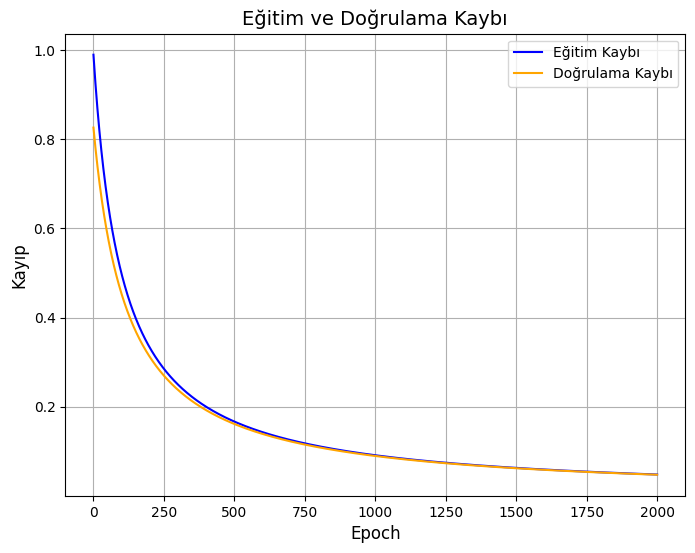

In [97]:
import matplotlib.pyplot as plt

# Örnek veri: Eğitim ve doğrulama kayıpları
# Bu değerleri kendi modelinizin `history` nesnesinden almanız gerekiyor.
epochs = range(1, 2001)  # 1'den 2000'e kadar epoch'lar
train_loss = [1 / (0.01 * x + 1) for x in epochs]  # Örnek eğitim kaybı verisi
val_loss = [1 / (0.01 * x + 1.2) for x in epochs]  # Örnek doğrulama kaybı verisi

# Grafik oluşturma
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label='Eğitim Kaybı', color='blue')
plt.plot(epochs, val_loss, label='Doğrulama Kaybı', color='orange')
plt.title('Eğitim ve Doğrulama Kaybı', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Kayıp', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True)
plt.show()


In [99]:
# sınıflarımız
label_dict = {
    0: "Suicidal Thoughts",
    1: "Eating Disorders",
    2: "Sleep Disorders",
    3: "Sexual Disorders",
    4: "Addictions",
    5: "Anger Control Disorders",
    6: "Borderline",
    7: "Psychosomatic Disorders",
    8: "OCD (Obsessive-Compulsive Disorder)",
    9: "Behavioral Disorders in Children",
    10: "Depression and Related Disorders",
    11: "Family and Relationship Issues",
    12: "Sports Psychology",
    13: "Attention Deficit and Hyperactivity Disorder (ADHD)",
    14: "Trauma",
    15: "Paraphilic Disorders"
}


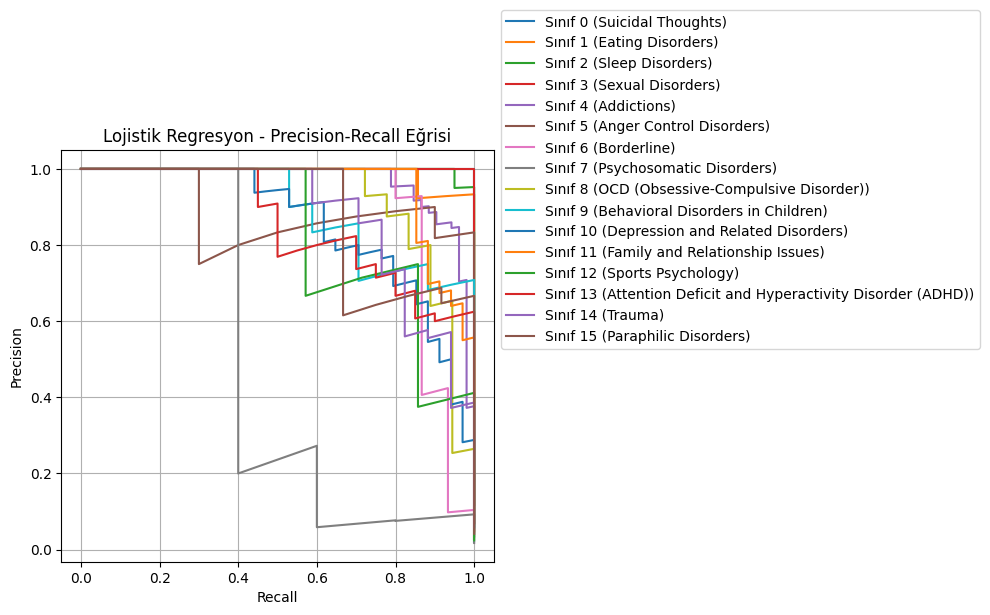

In [100]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Lojistik Regresyon için tahminler ve gerçek etiketler
y_prob_logistic = logistic_model.predict_proba(X_test)  # Tahmin olasılıkları

# Precision-Recall eğrisi
plt.figure(figsize=(10, 6))

for i in range(len(np.unique(y))):  # Her sınıf için precision-recall eğrisini çiziyoruz
    precision, recall, _ = precision_recall_curve(y_test == i, y_prob_logistic[:, i])
    plt.plot(recall, precision, label=f'Sınıf {i} ({label_dict.get(i, "Bilinmeyen")})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Lojistik Regresyon - Precision-Recall Eğrisi')
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()



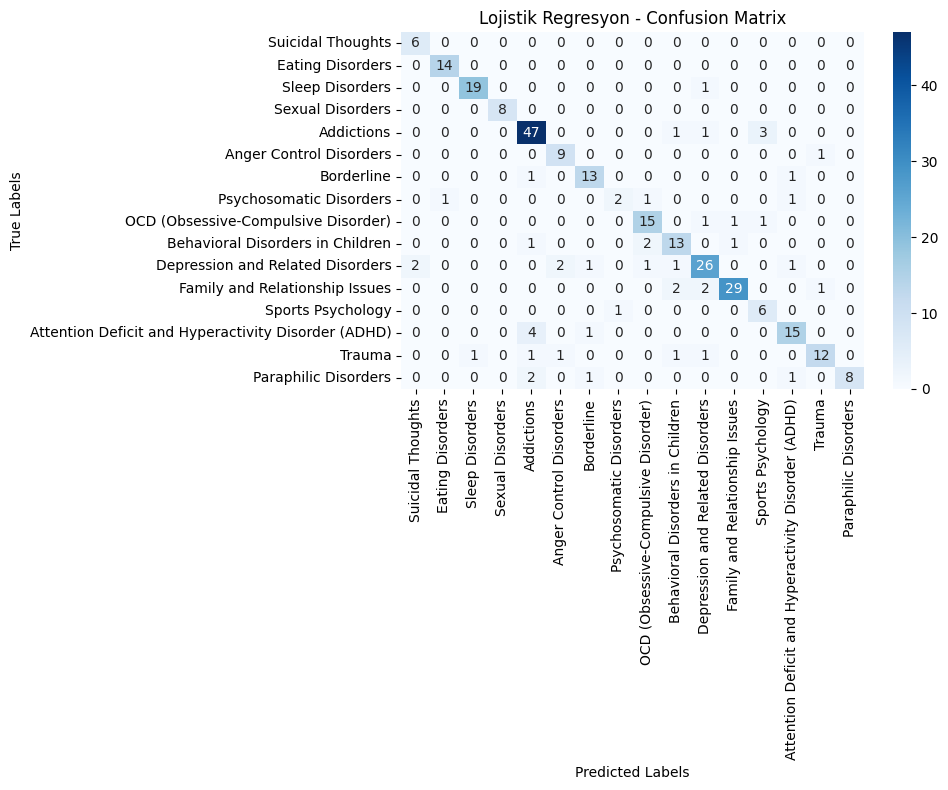

In [101]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Lojistik Regresyon için tahminler
y_pred_logistic = logistic_model.predict(X_test)

# Confusion Matrix hesaplayalım
cm = confusion_matrix(y_test, y_pred_logistic)

# Confusion Matrix'i görselleştirelim
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_dict.values()), yticklabels=list(label_dict.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Lojistik Regresyon - Confusion Matrix')
plt.tight_layout()
plt.show()
